# Benchmark Analysis

In this notebook the benchamrk used to evaluate MasekdIP Reservoir are studied and evalauted, analyzing the probability distribution of the domani and range of the non linear functions (or better ODEs corresponding to the described dynamical systems).

### Import and Plotters

In [1]:
import sys  
sys.path.insert(1, '.\..\..\SOURCES\.')

import random

random.seed(10)

from DATA import MG17, NARMA10, ContinousXOR, InubushiFunction

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
import torch

def plot_distribution(tensor, title='Distribution Plot'):
    """
    Plot the distribution of a unidimensional PyTorch tensor.

    Parameters:
    - tensor: 1D PyTorch tensor
    """
    # Convert PyTorch tensor to NumPy array
    data = tensor.cpu().numpy()

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Adjust figure size if needed
    plt.figure(figsize=(10, 6))

    # Create distribution plot using Seaborn
    sns.histplot(data, kde=True, bins='auto', color='blue', stat='density')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Density')

    plt.show()


In [3]:
def fit_and_plot_gmm(tensor, n_components=1):
    """
    Fit a Gaussian Mixture Model (GMM) to a unidimensional PyTorch tensor and plot the distribution.

    Parameters:
    - tensor: 1D PyTorch tensor
    - n_components: Number of Gaussian components in the mixture model

    Returns:
    - gmm: Fitted Gaussian Mixture Model
    """
    # Convert PyTorch tensor to NumPy array
    data = tensor.cpu().numpy()

    # Reshape data to 2D array
    data = data.reshape(-1, 1)

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data)

    # Check if the fit was successful
    if not hasattr(gmm, 'means_'):
        raise ValueError("Gaussian Mixture Model fit was unsuccessful. Check input data and parameters.")

    # Generate data points for plotting the distribution curve
    x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
    y = np.exp(gmm.score_samples(x))

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Adjust figure size if needed
    plt.figure(figsize=(10, 6))

    # Plot the histogram and the estimated distribution curve
    sns.histplot(data, kde=True, bins='auto', color='blue', stat='density', label='Data Distribution')
    plt.plot(x, y, color='red', label='GMM Fit')

    # Add title and labels
    plt.title('Gaussian Mixture Model Fit')
    plt.xlabel('Values')
    plt.ylabel('Density')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

    # Print GMM parameters
    print("GMM Parameters:")
    print(f"Means: {gmm.means_.flatten()}")
    print(f"Covariances: {gmm.covariances_.flatten()}")
    print(f"Weights: {gmm.weights_}")

    return gmm

# Example usage:
# Assuming your tensor is called 'my_tensor'
# gmm_model = fit_and_plot_gmm(my_tensor, n_components=2)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import torch
import torch.nn.functional as F
import numpy as np

def kl_divergence(p, q):
    """
    Calculate the KL divergence between two probability distributions.

    Parameters:
    - p: PyTorch tensor representing the true distribution
    - q: PyTorch tensor representing the estimated distribution

    Returns:
    - KL divergence
    """
    return F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')

def fit_and_plot_gmm_best_components(tensor, max_components=5):
    """
    Fit a Gaussian Mixture Model (GMM) to a unidimensional PyTorch tensor, plot the distribution,
    and choose the best number of components based on KL divergence.

    Parameters:
    - tensor: 1D PyTorch tensor
    - max_components: Maximum number of Gaussian components to consider

    Returns:
    - best_gmm: Fitted Gaussian Mixture Model with the best number of components
    """
    # Convert PyTorch tensor to NumPy array
    data = tensor.cpu().numpy()

    # Reshape data to 2D array
    data = data.reshape(-1, 1)

    # Initialize variables for best components and best KL divergence
    best_components = 1
    best_kl_divergence = float('inf')
    
    for n_components in range(1, max_components + 1):
        # Fit Gaussian Mixture Model
        gmm = BayesianGaussianMixture(n_components=n_components)
        gmm.fit(data)

        # Generate data points for plotting the distribution curve
        x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
        y = np.exp(gmm.score_samples(x))

        # Calculate KL divergence
        kl_div = kl_divergence(torch.from_numpy(data), torch.from_numpy(y))

        # Print KL divergence for each number of components
        print(f"KL Divergence (Components={n_components}): {kl_div.item()}")

        # Update best components if KL divergence is lower
        if kl_div < best_kl_divergence:
            best_components = n_components
            best_kl_divergence = kl_div

    # Fit GMM with the best number of components
    best_gmm = BayesianGaussianMixture(n_components=best_components)
    best_gmm.fit(data)

    # Generate data points for plotting the distribution curve with the best components
    x_best = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
    y_best = np.exp(best_gmm.score_samples(x_best))

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Adjust figure size if needed
    plt.figure(figsize=(10, 6))

    # Plot the histogram, the estimated distribution curve, and the best components curve
    sns.histplot(data, kde=True, bins='auto', color='blue', stat='density', label='Data Distribution')
    plt.plot(x_best, y_best, color='orange', linestyle='--', label=f'Best GMM Fit (Components={best_components})')

    # Add title and labels
    plt.title('Gaussian Mixture Model Fit (Best Components)')
    plt.xlabel('Values')
    plt.ylabel('Density')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

    # Print best GMM parameters
    print("Best GMM Parameters:")
    print(f"Means: {best_gmm.means_.flatten()}")
    print(f"Covariances: {best_gmm.covariances_.flatten()}")
    print(f"Weights: {best_gmm.weights_}")

    return best_gmm

# Example usage:
# Assuming your tensor is called 'my_tensor'
# best_gmm_model = fit_and_plot_gmm_best_components(my_tensor, max_components=5)

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_slice_with_range_separate_lines_xy(x_values, y_values, start_idx, end_idx, title = "Mackeyy Glass 17 Timeseries"):
    # Check if the lengths of x_values and y_values are consistent
    if len(x_values) != len(y_values):
        raise ValueError("Mackeyy Glass 17 Timeseries")

    # Check if the specified range is valid
    if start_idx >= end_idx or end_idx > len(x_values):
        raise ValueError("Invalid range specified.")

    # Slice the data within the specified range
    x_slice = x_values[start_idx:end_idx]
    y_slice = y_values[start_idx:end_idx]

    # Create a line plot for X values
    sns.lineplot(x=range(start_idx, end_idx), y=x_slice,  linestyle="--")

    # Create a line plot for Y values
    sns.lineplot(x=range(start_idx, end_idx), y=y_slice)

    # Add labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.title(f'{title} - Range: {start_idx} to {end_idx}')

    # Show the legend
    #plt.legend()

    # Show the plot
    plt.show()



## Mackye Glass

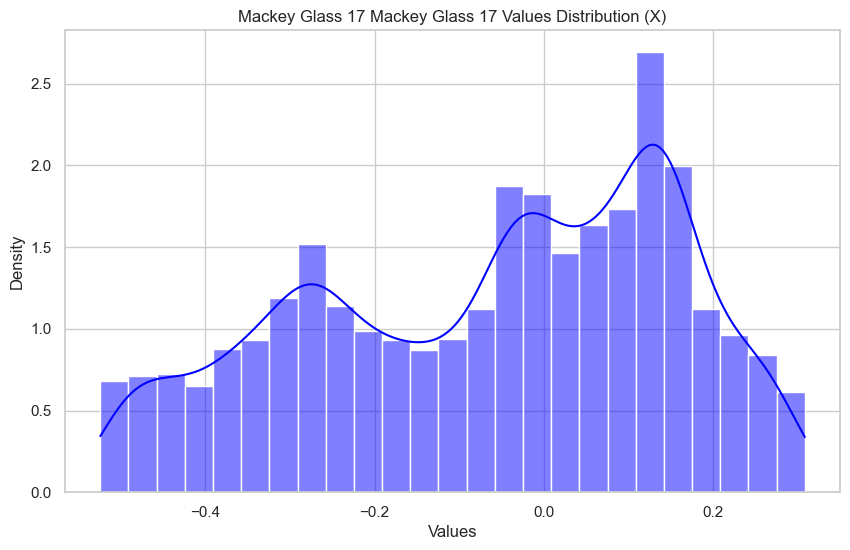

In [6]:
plot_distribution(MG17(split=False).X_DATA, "Mackey Glass 17 Mackey Glass 17 Values Distribution (X)")

In [19]:
MG17(split=False).X_DATA.shape

torch.Size([9999])

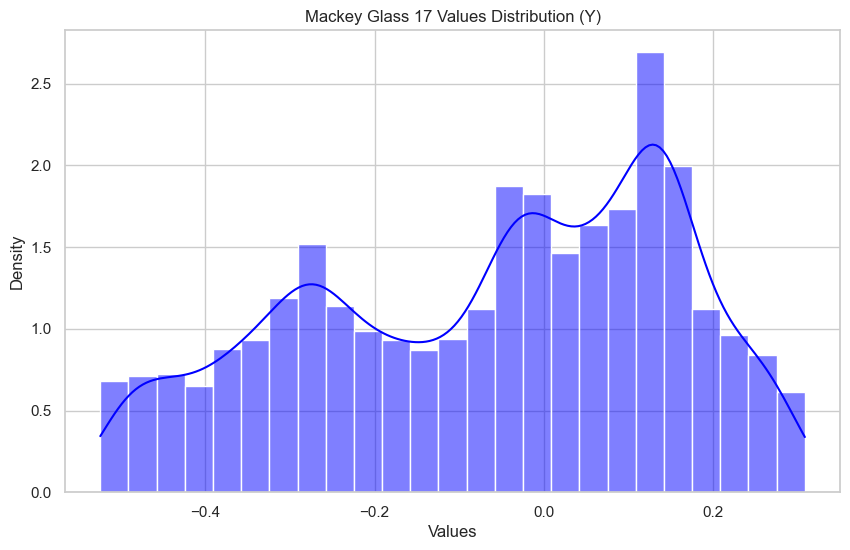

In [7]:
plot_distribution(MG17(split=False).Y_DATA, "Mackey Glass 17 Values Distribution (Y)")

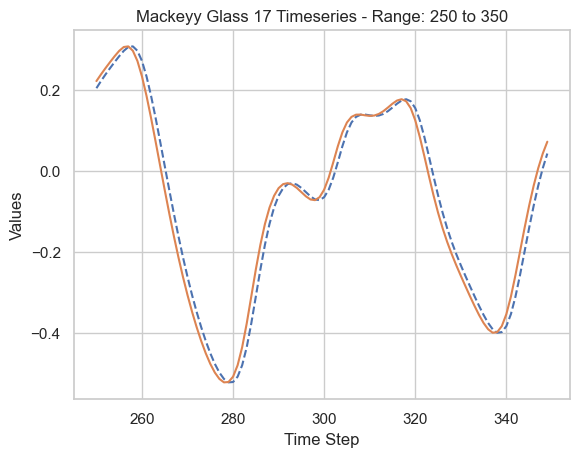

In [8]:
# Example usage
# Assuming you have lists named 'x_values' and 'y_values'
# Replace 'x_values' and 'y_values' with your actual data
plot_slice_with_range_separate_lines_xy(MG17(split=False).X_DATA, MG17(split=False).Y_DATA, start_idx=250, end_idx=350)


## NARMA 10

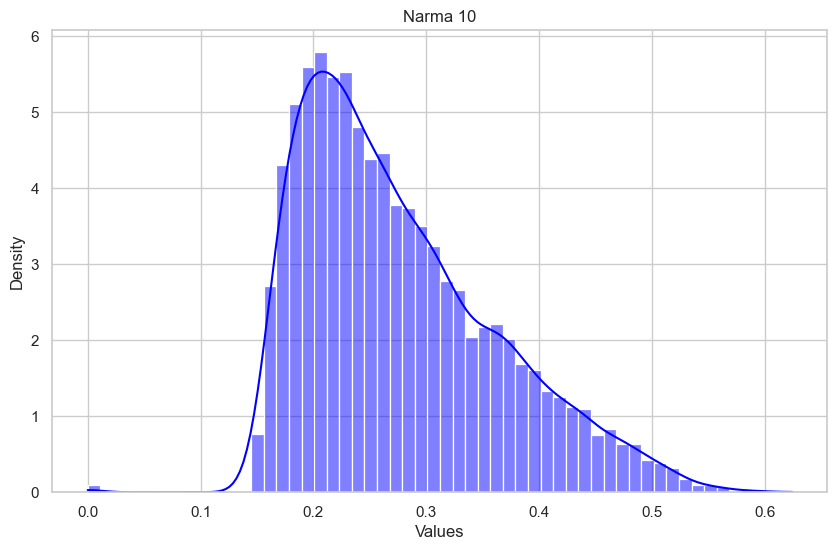

In [9]:
plot_distribution(NARMA10(split=False).X_DATA, "Narma 10")

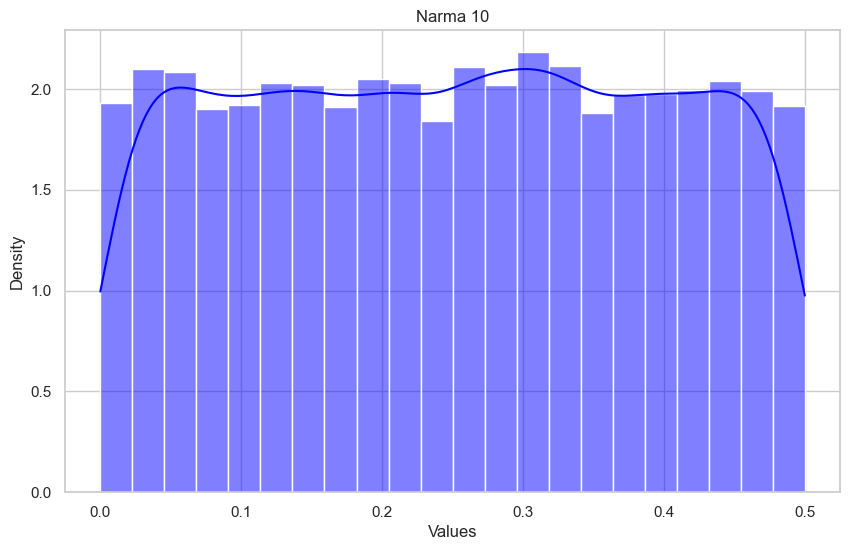

In [10]:
plot_distribution(NARMA10(split=False).Y_DATA, "Narma 10")

## Inubushi Non Linear Function

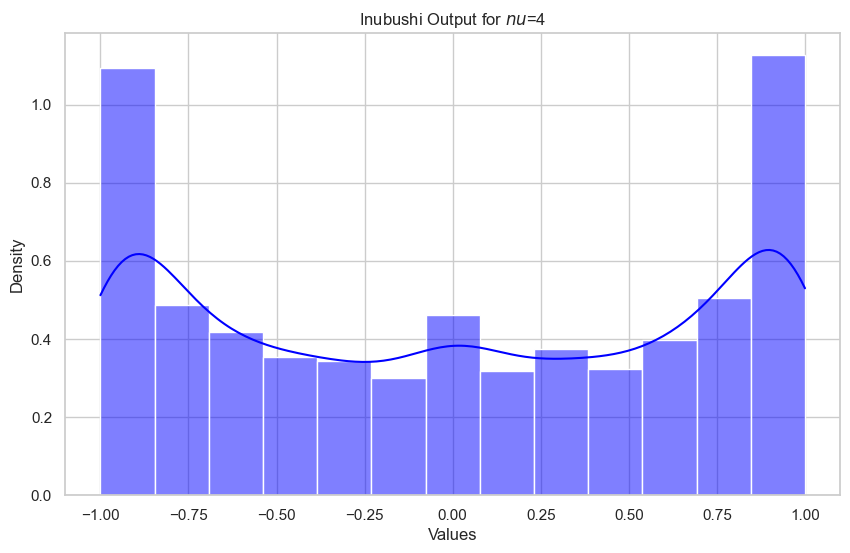

In [11]:
nu = 4
tau = 1
data = InubushiFunction(nu=nu)
data.delay_timeseries(tau)
data.split([80,0,20])

X_Inubushi, Y_Inubushi = data.TR()

plot_distribution(Y_Inubushi, f"Inubushi Output for $nu$={nu}")




### Varying $\nu$

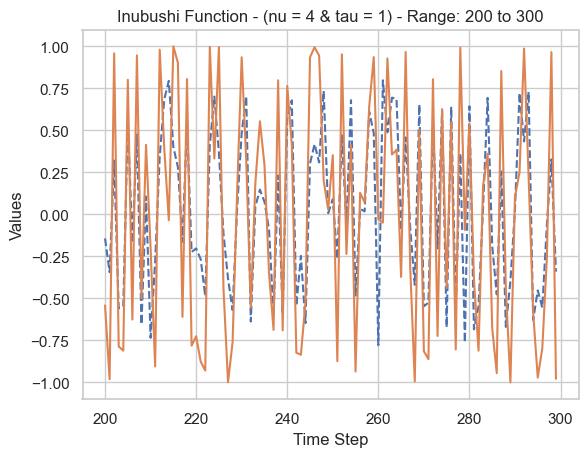

In [12]:
plot_slice_with_range_separate_lines_xy(X_Inubushi, Y_Inubushi, start_idx=200, end_idx=300, title=f'Inubushi Function - (nu = {nu} & tau = {tau})')


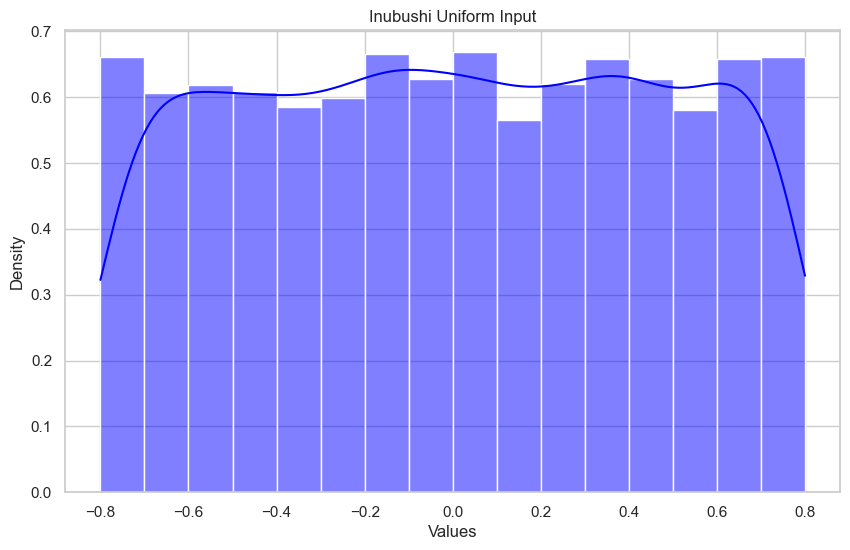

In [13]:
plot_distribution(X_Inubushi, "Inubushi Uniform Input")

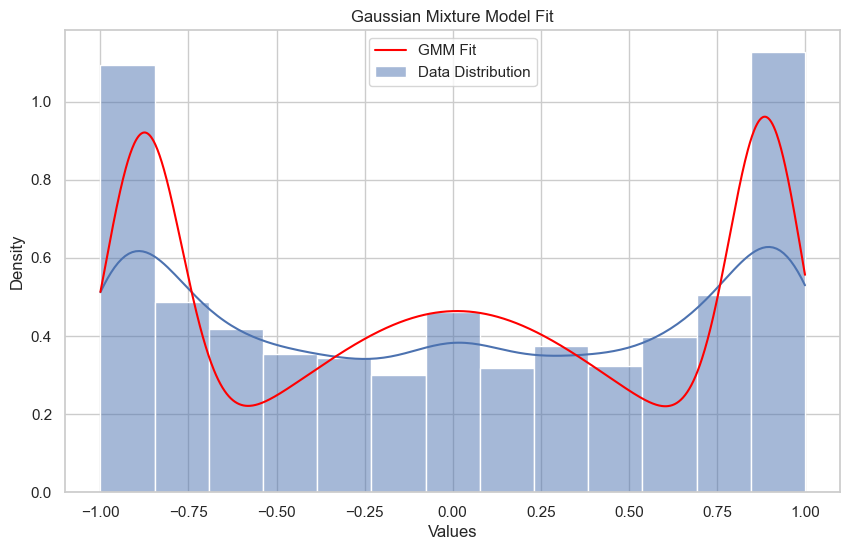

GMM Parameters:
Means: [ 0.88971188 -0.87921375  0.01206716]
Covariances: [0.01106681 0.01242832 0.20568143]
Weights: [0.23449682 0.23835771 0.52714547]


GaussianMixture(n_components=3)

In [14]:
fit_and_plot_gmm(Y_Inubushi, 3)

## Dambre Continuous XOR

In [15]:
p = 3.14
tau = 1

data = ContinousXOR(p)
data.delay_timeseries(tau)
data.split([100,0,0])

X_Dambre, Y_Dambre = data.TR()


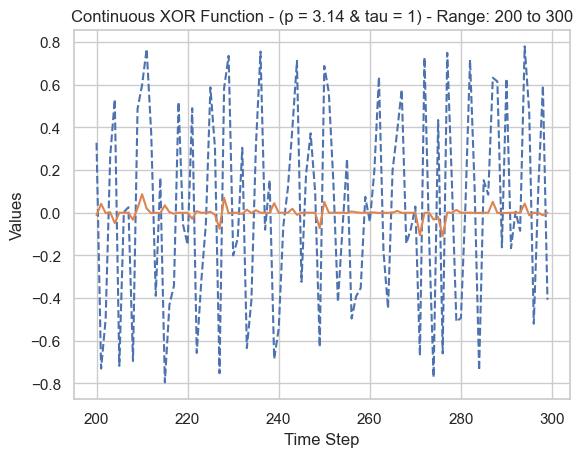

In [16]:
plot_slice_with_range_separate_lines_xy(X_Dambre, Y_Dambre, start_idx=200, end_idx=300, title=f'Continuous XOR Function - (p = {p} & tau = {tau})')

In [17]:
#plot_distribution(X_Dambre, "Continuous XOR input")

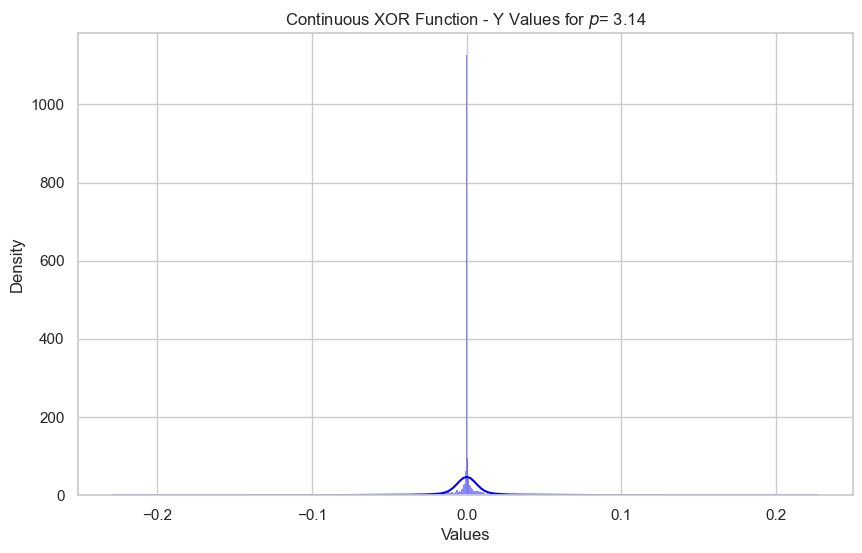

In [18]:

plot_distribution(Y_Dambre, f"Continuous XOR Function - Y Values for $p$= {p}")